# 初始化Graph插件参数

In [67]:
%%graph_notebook_vis_options
{
  "nodes": {
    "borderWidthSelected": 0,
    "borderWidth": 0,
    "color": {
      "background": "rgba(210, 229, 255, 1)",
      "border": "transparent",
      "highlight": {
        "background": "rgba(9, 104, 178, 1)",
        "border": "rgba(8, 62, 100, 1)"
      }
    },
    "shadow": {
      "enabled": false
    },
    "shape": "circle",
    "widthConstraint": {
      "minimum": 30,
      "maximum": 70
    },
    "font": {
      "face": "courier new",
      "color": "black",
      "size": 12
    }
  },
  "edges": {
    "color": {
      "inherit": false
    },
    "smooth": {
      "enabled": true,
      "type": "straightCross"
    },
    "arrows": {
      "to": {
        "enabled": true,
        "type": "arrow"
      }
    },
    "font": {
      "face": "courier new"
    }
  },
  "interaction": {
    "hover": true,
    "hoverConnectedEdges": true,
    "selectConnectedEdges": false
  },
  "physics": {
    "minVelocity": 0.75,
    "barnesHut": {
      "centralGravity": 0.1,
      "gravitationalConstant": -30450,
      "springLength": 105,
      "springConstant": 0.04,
      "damping": 0.09,
      "avoidOverlap": 0.5
    },
    "solver": "barnesHut",
    "enabled": true,
    "adaptiveTimestep": true,
    "stabilization": {
      "enabled": true,
      "iterations": 1
    }
  }
}


# 借助图数据库进行关联查询

## CHPO可视化

### 在特定表型分类下，查询不同表型之间的关联
由于实体间的关系是 ***Phenotypic->PhenotypicCategory->Term*** , 所以对Term来说要查询表型, 需要递归 **in** 关系的节点, 通过 **repeat** 操作可重复查询 **in** 节点，再通过 **until** 限定终止条件为:
+ 表型的中文名为 **['脑肉芽肿','肺炎','酒后面部潮红','牙龈出血']** 四者之一<br/>

从表型来看四者分别描述的人体不同部位，但从查询结果来看四者之间有一定关联，且相关性有差异，如 **"牙龈出血"** 和 **"脑肉芽肿"** 都属于 **"血液和造血组织异常"** 分类，相关性更近。
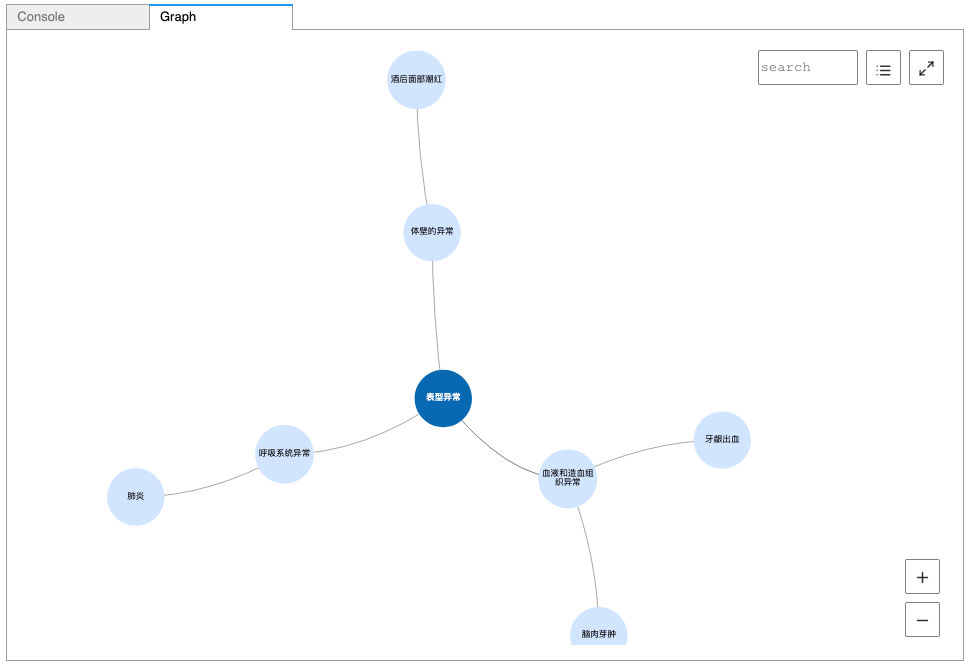

In [1]:
%%gremlin -p v,v,v
g.V("表型异常").hasLabel('Term')
.repeat(
    in()
)
.until(
    has('name_cn',within('脑肉芽肿','肺炎','酒后面部潮红','牙龈出血'))
)
.simplepath()
.by(id)
.by(id)
.by('name_cn')


### 查询不同表型之间的关联
表型分类与表型之间存在着多对多的关系，所以从已知表型出发查询关系也是有必要的，下面的示例是从表型出发，分别查找不同表型所属的分类。
从结果来看:
+ **结膜炎** 、**结膜血管迂曲** 、**视网膜萎缩** 均与 **眼睛的异常** 相关
+ **结膜炎** 、**结膜血管迂曲** 均和 **头或颈部异常** 相关
+ **结膜炎** 、**结膜血管迂曲** 分别和 **免疫系统异常** 、 **心血管系统异常** 相关

从“结膜血管迂曲”表型出发，查询该表型关联的表型分类
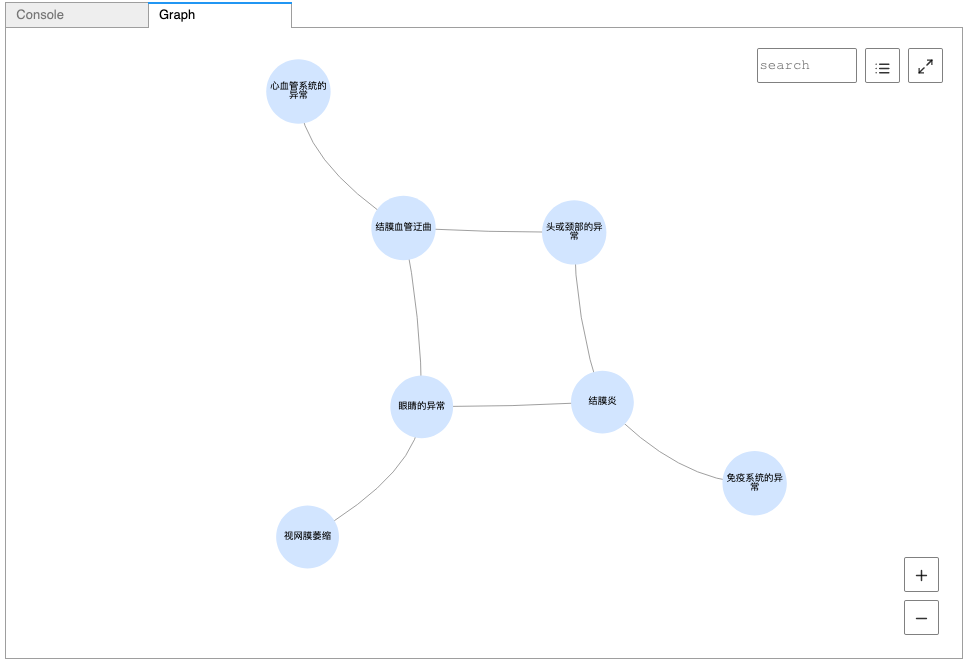

In [2]:
%%gremlin -p v,v,v
g.V().hasLabel('Phenotypic').has('name_cn',within('结膜血管迂曲','结膜炎','视网膜萎缩'))
.repeat(
    out()
)
.until(hasLabel('PhenotypicCategory'))
.simplepath()
.by('name_cn')
.by(id)
.by(id)

## CHPO结合OMIM可视化分析
### 统计查找阿尔茨海默病相关基因，以及表型所属的分类
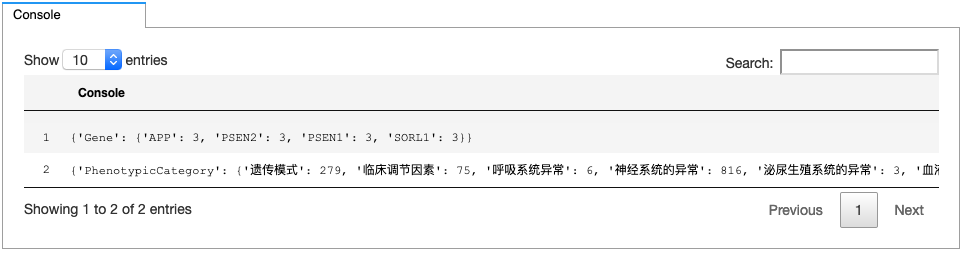

In [3]:
%%gremlin -p v,outv,outv,outv
g.V().has('OMIM','disease_name_cn',containing('阿尔茨海默病'))
.out()
.groupCount('Gene').by(id)
.repeat(out())
.until(
    hasLabel('PhenotypicCategory')
)
.groupCount('PhenotypicCategory').by(id)
.cap('Gene','PhenotypicCategory')
.unfold()


与阿尔兹海默症相关联的基因查找
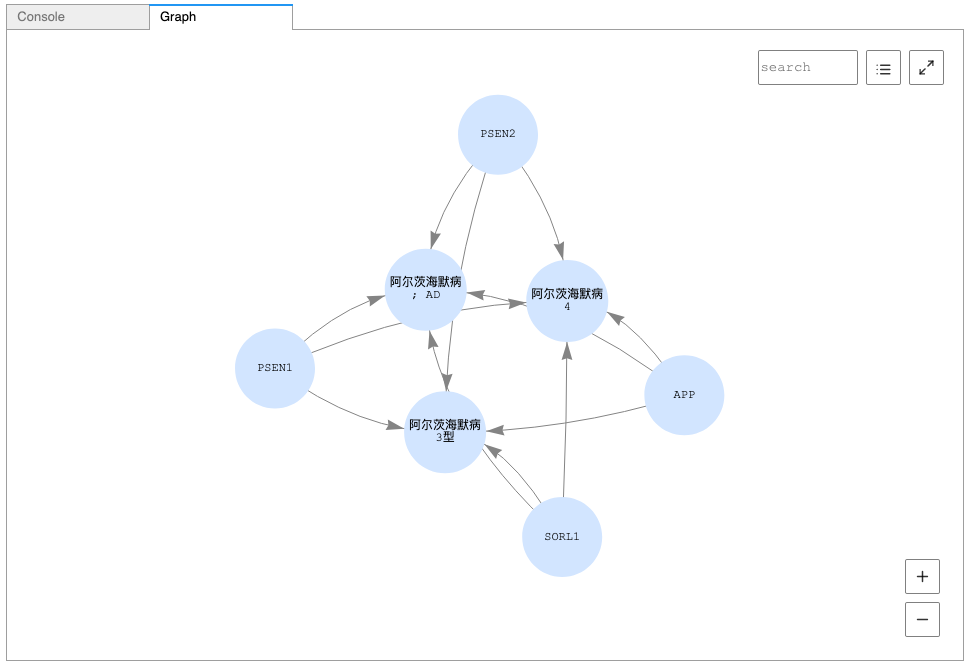

In [66]:
%%gremlin -p v,outv
g.V().has('OMIM','disease_name_cn',containing('阿尔茨海默病'))
.out()
.simplepath()
.by('disease_name_cn')
.by(id)

我们看到与 **阿尔茨海默病** 相关的Gene主要是 **[APP,SORL1,PSEN1,PSEN2]** ,我们也可以尝试查询这几个基因分别与哪些疾病表型相关，包括这些表型的分类
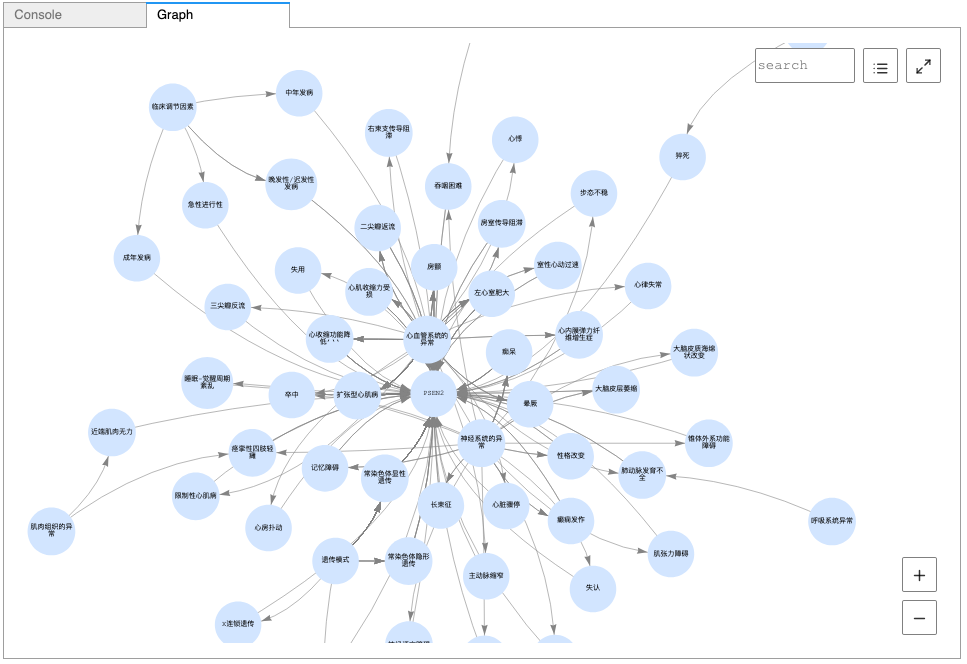

In [65]:
%%gremlin -p v,outv,outv,outv
g.V().hasId(within('PSEN1','PSEN2','SORL1','APP'))
.repeat(out())
.until(hasLabel('PhenotypicCategory'))
.simplepath()
.by(id)
.by('name_cn')
.by(id)
.limit(150)


**['PSEN1','PSEN2','SORL1','APP']** 这几个基因关联到的表型中，分类于 **神经系统异常** 的最多，其次 **心血管系统的异常**
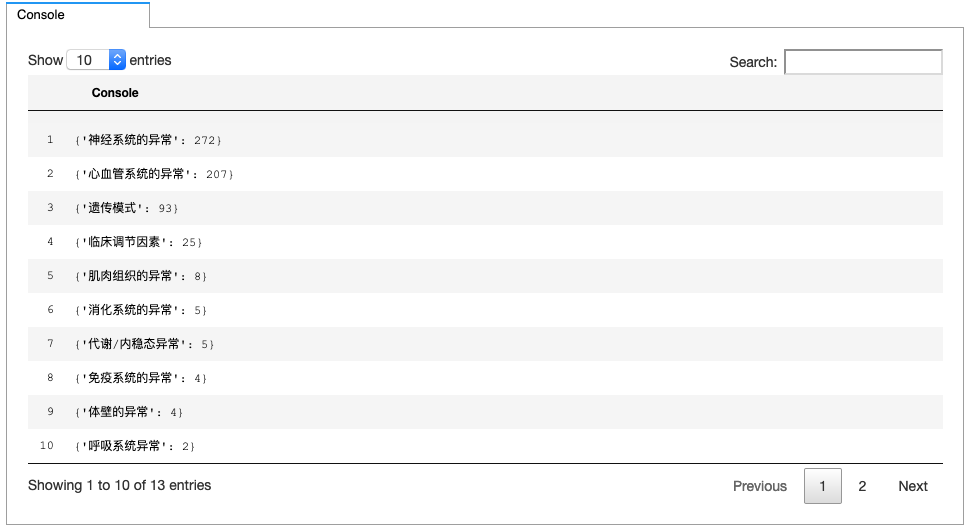

In [6]:
%%gremlin -p v,outv,outv,outv
g.V().hasId(within('PSEN1','PSEN2','SORL1','APP'))
.repeat(out())
.until(hasLabel('PhenotypicCategory'))
.groupCount()
.by(id)
.order(Scope.local).by(values, Order.decr)
.unfold()

在上面的例子中我们会发现，有很多疾病、表型只与某一个gene相关，而我们想找的是共同基因变异引起的疾病/表型，我们可以按照如下方式查询，结果中显示的每个表型至少与 **[APP,SORL1,PSEN1,PSEN2]** 中的任意两个有关联
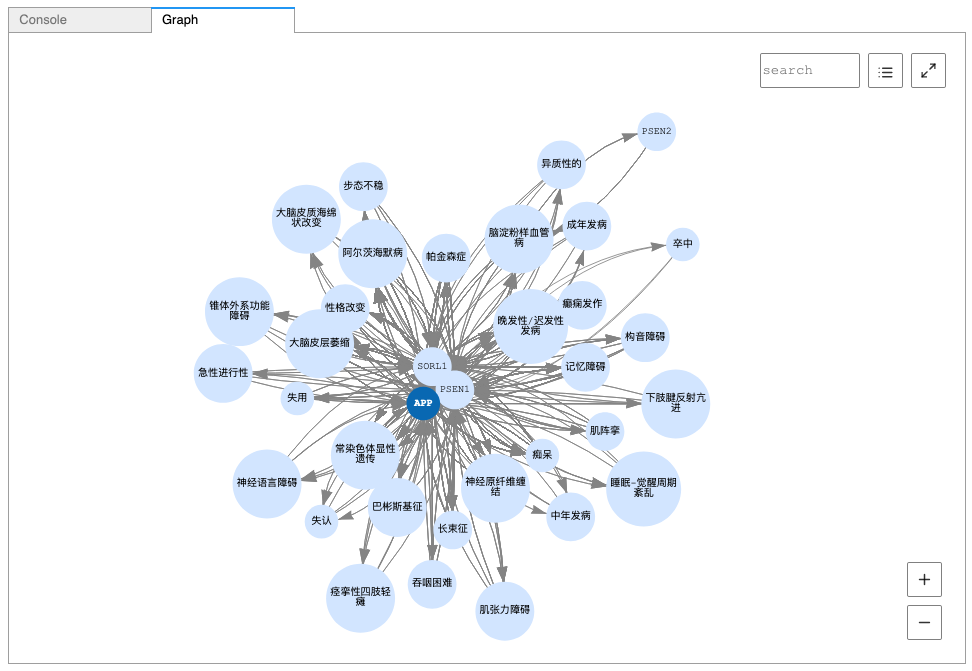

In [63]:
%%gremlin -p v,outv,outv,outv
g.V().hasId(within('PSEN1','PSEN2','SORL1','APP')).as('sg').aggregate('gene')
.out()
.in()
.where(P.within('gene')).where(P.neq('sg'))
.simplepath()
.by(id)
.by('name_cn')
.by(id)
